In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("US_Accidents_50k.csv")
print(df.shape)
df.head()

(50000, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3135565,Source2,3,2017-12-18 20:39:26,2017-12-18 21:24:05,26.231586,-80.136581,NaN,NaN,0.000,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-3933005,Source1,2,2022-01-12 08:33:00,2022-01-12 10:46:35,28.541458,-81.475852,28.539172,-81.475874,0.158,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-1263310,Source2,2,2020-11-17 10:36:29,2020-11-17 11:06:05,29.851583,-95.504662,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-7511056,Source1,2,2018-11-29 17:28:45,2018-11-29 21:28:44,42.148838,-121.698240,42.143724,-121.698269,0.353,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-7743457,Source1,2,2019-06-26 06:35:00,2019-06-26 07:45:00,40.914630,-111.891470,40.908653,-111.891500,0.413,...,False,False,False,False,False,False,Day,Day,Day,Day


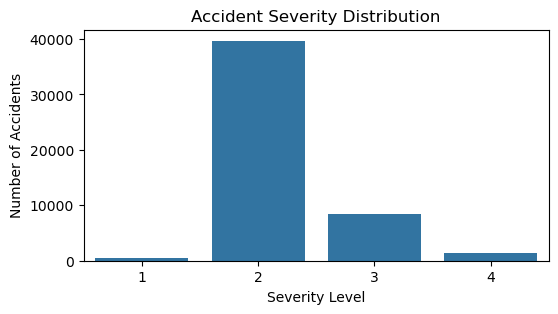

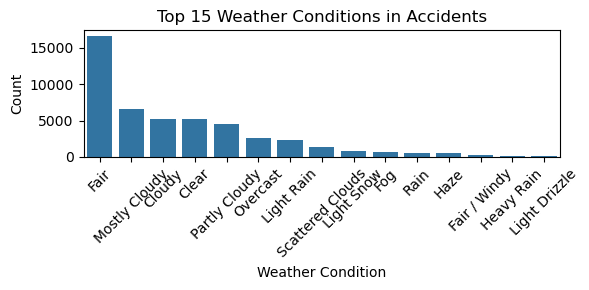

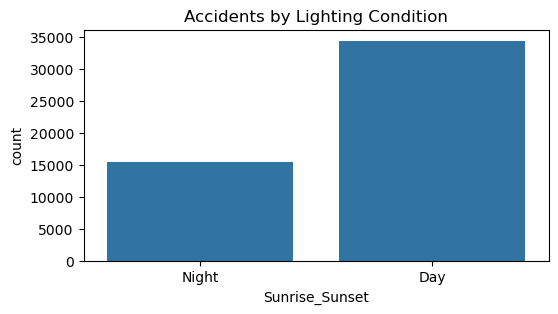

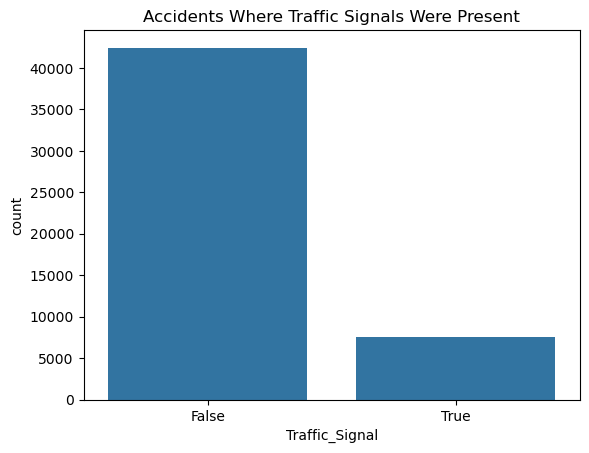

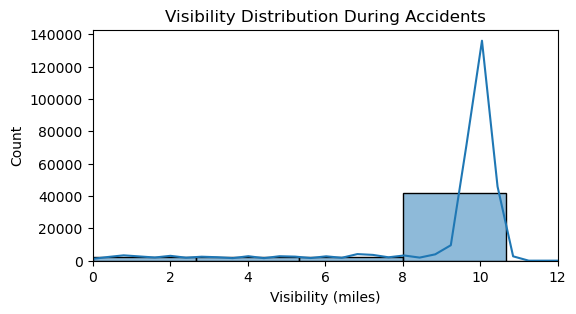

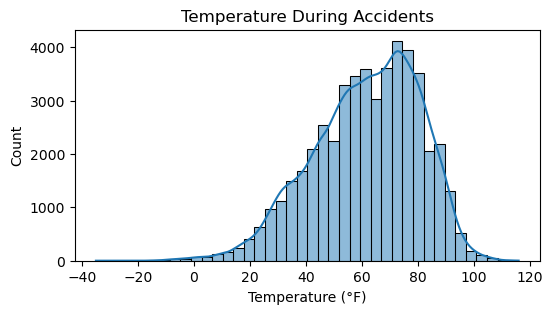

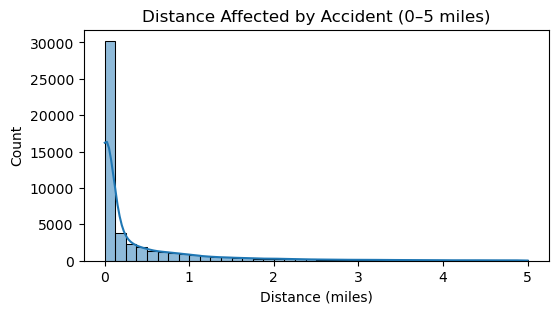

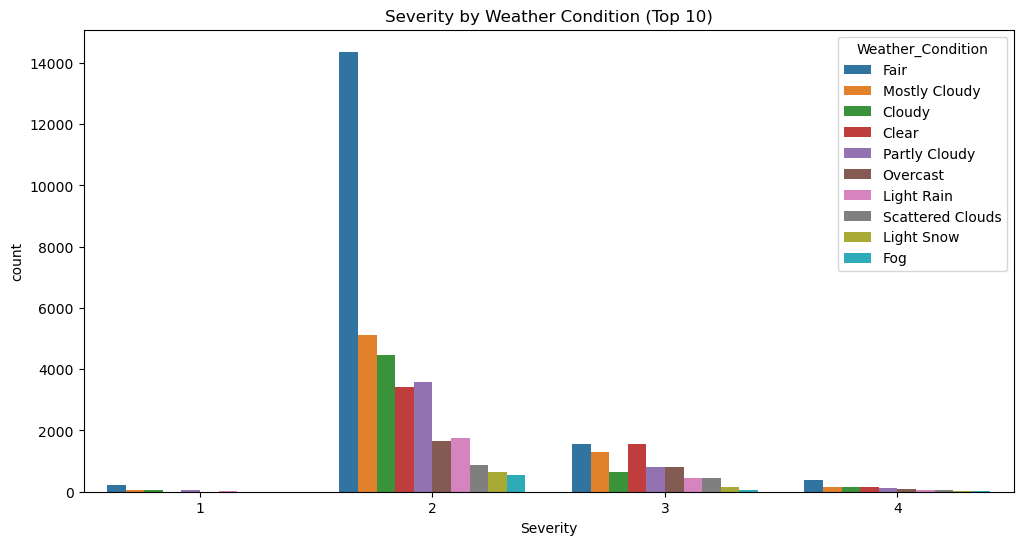

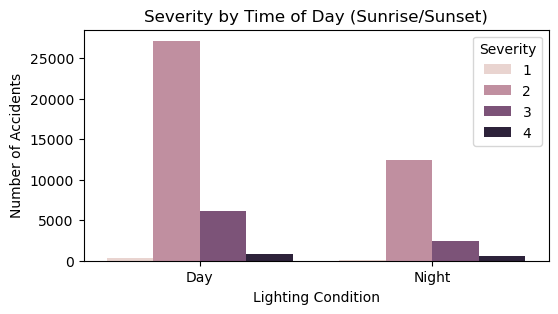

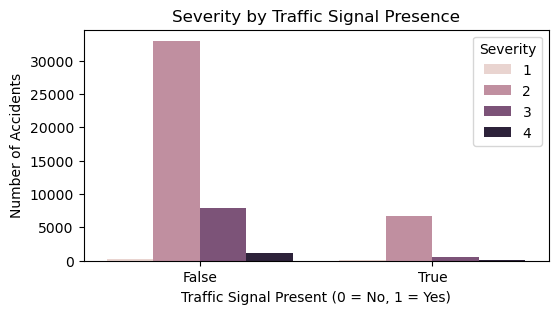

In [2]:
#Visualize the data -- Univariate
plt.figure(figsize=(6,3))
sns.countplot(x='Severity', data=df)
plt.title("Accident Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Number of Accidents")
plt.show()

plt.figure(figsize=(6,3))
top_weather = df['Weather_Condition'].value_counts().nlargest(15)
sns.barplot(x=top_weather.index, y=top_weather.values)
plt.title("Top 15 Weather Conditions in Accidents")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(x='Sunrise_Sunset', data=df)
plt.title("Accidents by Lighting Condition")
plt.show()

sns.countplot(x='Traffic_Signal', data=df)
plt.title("Accidents Where Traffic Signals Were Present")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df['Visibility(mi)'], bins=30, kde=True)
plt.title("Visibility Distribution During Accidents")
plt.xlim(0,12)
plt.xlabel("Visibility (miles)")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df['Temperature(F)'], bins=40, kde=True)
plt.title("Temperature During Accidents")
plt.xlabel("Temperature (°F)")
plt.show()

plt.figure(figsize=(6, 3))
filtered_df = df[df['Distance(mi)'] <= 5]
sns.histplot(filtered_df['Distance(mi)'], bins=40, kde=True)
plt.title("Distance Affected by Accident (0–5 miles)")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
plt.show()


#Visualize the data -- Multivariate
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Severity', hue='Weather_Condition',
              order=[1,2,3,4], hue_order=df['Weather_Condition'].value_counts().index[:10])
plt.title("Severity by Weather Condition (Top 10)")
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Sunrise_Sunset', hue='Severity', order=['Day', 'Night'], hue_order=[1,2,3,4])
plt.title("Severity by Time of Day (Sunrise/Sunset)")
plt.xlabel("Lighting Condition")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Traffic_Signal', hue='Severity', hue_order=[1,2,3,4])
plt.title("Severity by Traffic Signal Presence")
plt.xlabel("Traffic Signal Present (0 = No, 1 = Yes)")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.show()


In [3]:
#Preprocessing and some feature engineering

df_clean = df.copy()
print(f"Shape before preprocessing: {df_clean.shape}")

# Ensure 'Start_Time' and 'End_Time' are parsed correctly
df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
df_clean['End_Time'] = pd.to_datetime(df_clean['End_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Drop rows where timestamp conversion failed
rows_before_drop = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['Start_Time', 'End_Time'])
print(f"\nDropped {rows_before_drop - df_clean.shape[0]} rows due to invalid timestamps.")
print(f"Shape after dropping invalid datetimes: {df_clean.shape}")

# Create time-based features
df_clean['Hour'] = df_clean['Start_Time'].dt.hour
df_clean['DayOfWeek'] = df_clean['Start_Time'].dt.dayofweek #Monday-> 0 and Sunday->6
df_clean['Month'] = df_clean['Start_Time'].dt.month
df_clean['Year'] = df_clean['Start_Time'].dt.year
df_clean['Is_Weekend'] = df_clean['DayOfWeek'].isin([5, 6]).astype(int)

# Calculate Duration
df_clean['Duration(mins)'] = (df_clean['End_Time'] - df_clean['Start_Time']).dt.total_seconds() / 60

# handling potential negative durations
neg_duration_count = (df_clean['Duration(mins)'] < 0).sum()
if neg_duration_count > 0:
    print(f"Warning: Found {neg_duration_count} entries with negative duration. Setting them to 0.")
    df_clean.loc[df_clean['Duration(mins)'] < 0, 'Duration(mins)'] = 0

print("\nCreated time-based features: Hour, DayOfWeek, Month, Year, Is_Weekend, Duration(mins).")

# handling missing numerical values
num_cols_to_impute = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                      'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
print("\nImputing missing values in numerical columns using median:")
for col in num_cols_to_impute:
    median_val = df_clean[col].median()
    missing_count = df_clean[col].isna().sum()
    if missing_count > 0:
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f" - Filled {missing_count} missing values in '{col}' with median ({median_val:.2f})")

# encode sunset/sunrise
df_clean['Is_Night'] = df_clean['Sunrise_Sunset'].apply(lambda x: 1 if x == 'Night' else 0)
print("\nEncoded 'Sunrise_Sunset' into binary 'Is_Night' (1 for Night, 0 for Day).")

# missing severity drop
rows_before_drop = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['Severity'])
print(f"\nDropped {rows_before_drop - df_clean.shape[0]} rows with missing Severity.")

# remove excessively long duration accidents
max_duration_threshold = 1440
rows_before_drop = df_clean.shape[0]
df_clean = df_clean[df_clean['Duration(mins)'] <= max_duration_threshold]
print(f"Removed {rows_before_drop - df_clean.shape[0]} rows with Duration(mins) > {max_duration_threshold}.")
print(f"Shape after initial cleaning and feature engineering: {df_clean.shape}")

# simplify and encode weather
def map_weather_condition(condition):
    condition = str(condition).lower()
    if "fair" in condition or "clear" in condition:
        return "Clear"
    elif "cloud" in condition or "overcast" in condition or "scattered" in condition:
        return "Cloudy"
    elif "rain" in condition or "drizzle" in condition or "shower" in condition:
        return "Rain"
    elif "snow" in condition or "wintry" in condition or "ice" in condition:
        return "Snow"
    elif "fog" in condition or "haze" in condition or "mist" in condition or "smoke" in condition:
        return "Fog"
    elif "thunder" in condition or "t-storm" in condition:
        return "Thunderstorm"
    elif "windy" in condition or "squalls" in condition:
        return "Windy"
    else:
        return "Other"

df_clean['Weather_Simplified'] = df_clean['Weather_Condition'].apply(map_weather_condition)
print("\nMapped 'Weather_Condition' into simplified categories ('Weather_Simplified').")

# One-hot encode simplified weather categories to int
weather_dummies = pd.get_dummies(df_clean['Weather_Simplified'], prefix='Weather', dummy_na=False, dtype=int) # int conversion 0 / 1
df_clean = pd.concat([df_clean, weather_dummies], axis=1)
print(f"\nOne-hot encoded simplified weather (0/1). New cols: {list(weather_dummies.columns)}")

# low visibility flag for dangerously low visibility
low_vis_threshold = 3
df_clean['Low_Visibility_Flag'] = (df_clean['Visibility(mi)'] < low_vis_threshold).astype(int) # bool conversion 0 / 1
print(f"\nAdded 'Low_Visibility_Flag' (1 if Visibility(mi) < {low_vis_threshold}, else 0). "
      f"Count: {df_clean['Low_Visibility_Flag'].sum()}")


print(f"\nShape after Cell 3 processing: {df_clean.shape}")
print("\nColumns after Cell 3 processing:")
print(df_clean.columns.tolist())
print("\nSample of engineered features (first 5 rows):")
print(df_clean[['Start_Time', 'Hour', 'DayOfWeek', 'Is_Weekend', 'Duration(mins)', 'Is_Night', 'Weather_Simplified', 'Low_Visibility_Flag'] + list(weather_dummies.columns)].head())

Shape before preprocessing: (50000, 46)

Dropped 4778 rows due to invalid timestamps.
Shape after dropping invalid datetimes: (45222, 46)

Created time-based features: Hour, DayOfWeek, Month, Year, Is_Weekend, Duration(mins).

Imputing missing values in numerical columns using median:
 - Filled 910 missing values in 'Temperature(F)' with median (64.00)
 - Filled 12939 missing values in 'Wind_Chill(F)' with median (61.00)
 - Filled 972 missing values in 'Humidity(%)' with median (67.00)
 - Filled 778 missing values in 'Pressure(in)' with median (29.87)
 - Filled 999 missing values in 'Visibility(mi)' with median (10.00)
 - Filled 3528 missing values in 'Wind_Speed(mph)' with median (7.00)
 - Filled 14198 missing values in 'Precipitation(in)' with median (0.00)

Encoded 'Sunrise_Sunset' into binary 'Is_Night' (1 for Night, 0 for Day).

Dropped 0 rows with missing Severity.
Removed 189 rows with Duration(mins) > 1440.
Shape after initial cleaning and feature engineering: (45033, 53)

Mapp

In [4]:
# feature engineering

# convert bool cols to 0 / 1
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
             'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
             'Traffic_Signal', 'Turning_Loop']

print("\nConverting boolean columns to 0/1 integers:")
for col in bool_cols:
    if col in df_clean.columns:
        if df_clean[col].dtype == 'bool' or df_clean[col].dtype == 'object':
             df_clean[col] = df_clean[col].astype(int)
             print(f" - Converted '{col}' to integer.")
        #handling missing vals
        if df_clean[col].isna().any():
             mode_val = df_clean[col].mode()[0]
             missing_count = df_clean[col].isna().sum()
             df_clean[col] = df_clean[col].fillna(mode_val)
             print(f"   - Filled {missing_count} missing values in '{col}' with mode ({mode_val})")
    else:
        print(f" - Warning: Boolean column '{col}' not found.")

# handling wind direction
print("\nHandling 'Wind_Direction':")
if 'Wind_Direction' in df_clean.columns:
    # standardization
    wind_map = {
        'Calm': 'CALM', 'Variable': 'VAR',
        'East': 'E', 'North': 'N', 'South': 'S', 'West': 'W'
    }
    df_clean['Wind_Direction'] = df_clean['Wind_Direction'].replace(wind_map).str.upper()
    print(f" - Standardized 'Wind_Direction' values. Unique values now: {df_clean['Wind_Direction'].unique()}")
    # filling missing vals
    mode_wind = df_clean['Wind_Direction'].mode()[0]
    missing_count = df_clean['Wind_Direction'].isna().sum()
    if missing_count > 0:
        df_clean['Wind_Direction'] = df_clean['Wind_Direction'].fillna(mode_wind)
        print(f" - Filled {missing_count} missing 'Wind_Direction' with standardized mode ('{mode_wind}')")
    # encoding standardized wind directions
    wind_dummies = pd.get_dummies(df_clean['Wind_Direction'], prefix='WindDir', dummy_na=False)
    df_clean = pd.concat([df_clean, wind_dummies], axis=1)
    print(f" - One-hot encoded standardized 'Wind_Direction'. New columns: {list(wind_dummies.columns)}")
else:
    print(" - 'Wind_Direction' column not found.")

# high cardinality columns being dropped
high_card_cols = ['Street', 'City', 'County', 'Zipcode', 'Airport_Code']
text_cols = ['Description']
cols_to_drop_high_card = [col for col in high_card_cols if col in df_clean.columns]
cols_to_drop_text = [col for col in text_cols if col in df_clean.columns]

print(f"\nDropping high cardinality location columns: {cols_to_drop_high_card}")
df_clean = df_clean.drop(columns=cols_to_drop_high_card, errors='ignore')

print(f"Dropping text description column: {cols_to_drop_text}")
df_clean = df_clean.drop(columns=cols_to_drop_text, errors='ignore')


# keeping start lattitude / longitude, dropping end since they are redundant w/ distance
print("\nHandling Geospatial columns: Keeping Start_Lat/Start_Lng, dropping End_Lat/End_Lng.")
if 'End_Lat' in df_clean.columns:
    df_clean = df_clean.drop(columns=['End_Lat'], errors='ignore')
if 'End_Lng' in df_clean.columns:
    df_clean = df_clean.drop(columns=['End_Lng'], errors='ignore')

# checking missing vals for start lattitude and longitude, filling w/ median
geo_cols_to_check = ['Start_Lat', 'Start_Lng']
print("Checking for missing values in Start_Lat/Start_Lng:")
for col in geo_cols_to_check:
    if col in df_clean.columns:
         missing_count = df_clean[col].isna().sum()
         if missing_count > 0:
             median_val = df_clean[col].median()
             df_clean[col] = df_clean[col].fillna(median_val)
             print(f" - Filled {missing_count} missing values in '{col}' with median ({median_val:.4f})")
    else:
         print(f" - Column '{col}' not found.")


print(f"\nShape after Cell 4 processing: {df_clean.shape}")
print("\nColumns after Cell 4 processing:")
print(df_clean.columns.tolist())


Converting boolean columns to 0/1 integers:
 - Converted 'Amenity' to integer.
 - Converted 'Bump' to integer.
 - Converted 'Crossing' to integer.
 - Converted 'Give_Way' to integer.
 - Converted 'Junction' to integer.
 - Converted 'No_Exit' to integer.
 - Converted 'Railway' to integer.
 - Converted 'Roundabout' to integer.
 - Converted 'Station' to integer.
 - Converted 'Stop' to integer.
 - Converted 'Traffic_Calming' to integer.
 - Converted 'Traffic_Signal' to integer.
 - Converted 'Turning_Loop' to integer.

Handling 'Wind_Direction':
 - Standardized 'Wind_Direction' values. Unique values now: ['ESE' 'NE' 'ENE' 'CALM' 'SW' 'S' 'N' 'VAR' 'E' 'NNE' 'W' nan 'WNW' 'SSW'
 'WSW' 'NW' 'NNW' 'SSE' 'SE']
 - Filled 946 missing 'Wind_Direction' with standardized mode ('CALM')
 - One-hot encoded standardized 'Wind_Direction'. New columns: ['WindDir_CALM', 'WindDir_E', 'WindDir_ENE', 'WindDir_ESE', 'WindDir_N', 'WindDir_NE', 'WindDir_NNE', 'WindDir_NNW', 'WindDir_NW', 'WindDir_S', 'WindDir_S


Columns identified for dropping: ['ID', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Sunrise_Sunset', 'Weather_Condition', 'Weather_Simplified', 'Wind_Direction', 'State', 'Timezone', 'Source', 'Country', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Wind_Chill(F)']

Shape after dropping columns: (45033, 57)

Remaining columns (features + target):
['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Hour', 'DayOfWeek', 'Month', 'Year', 'Is_Weekend', 'Duration(mins)', 'Is_Night', 'Weather_Clear', 'Weather_Cloudy', 'Weather_Fog', 'Weather_Other', 'Weather_Rain', 'Weather_Snow', 'Weather_Thunderstorm', 'Weather_Windy', 'Low_Visibility_Flag', 'WindDir_CALM', 'WindDir_E', 'WindDir_ENE', 'WindDir_ESE'

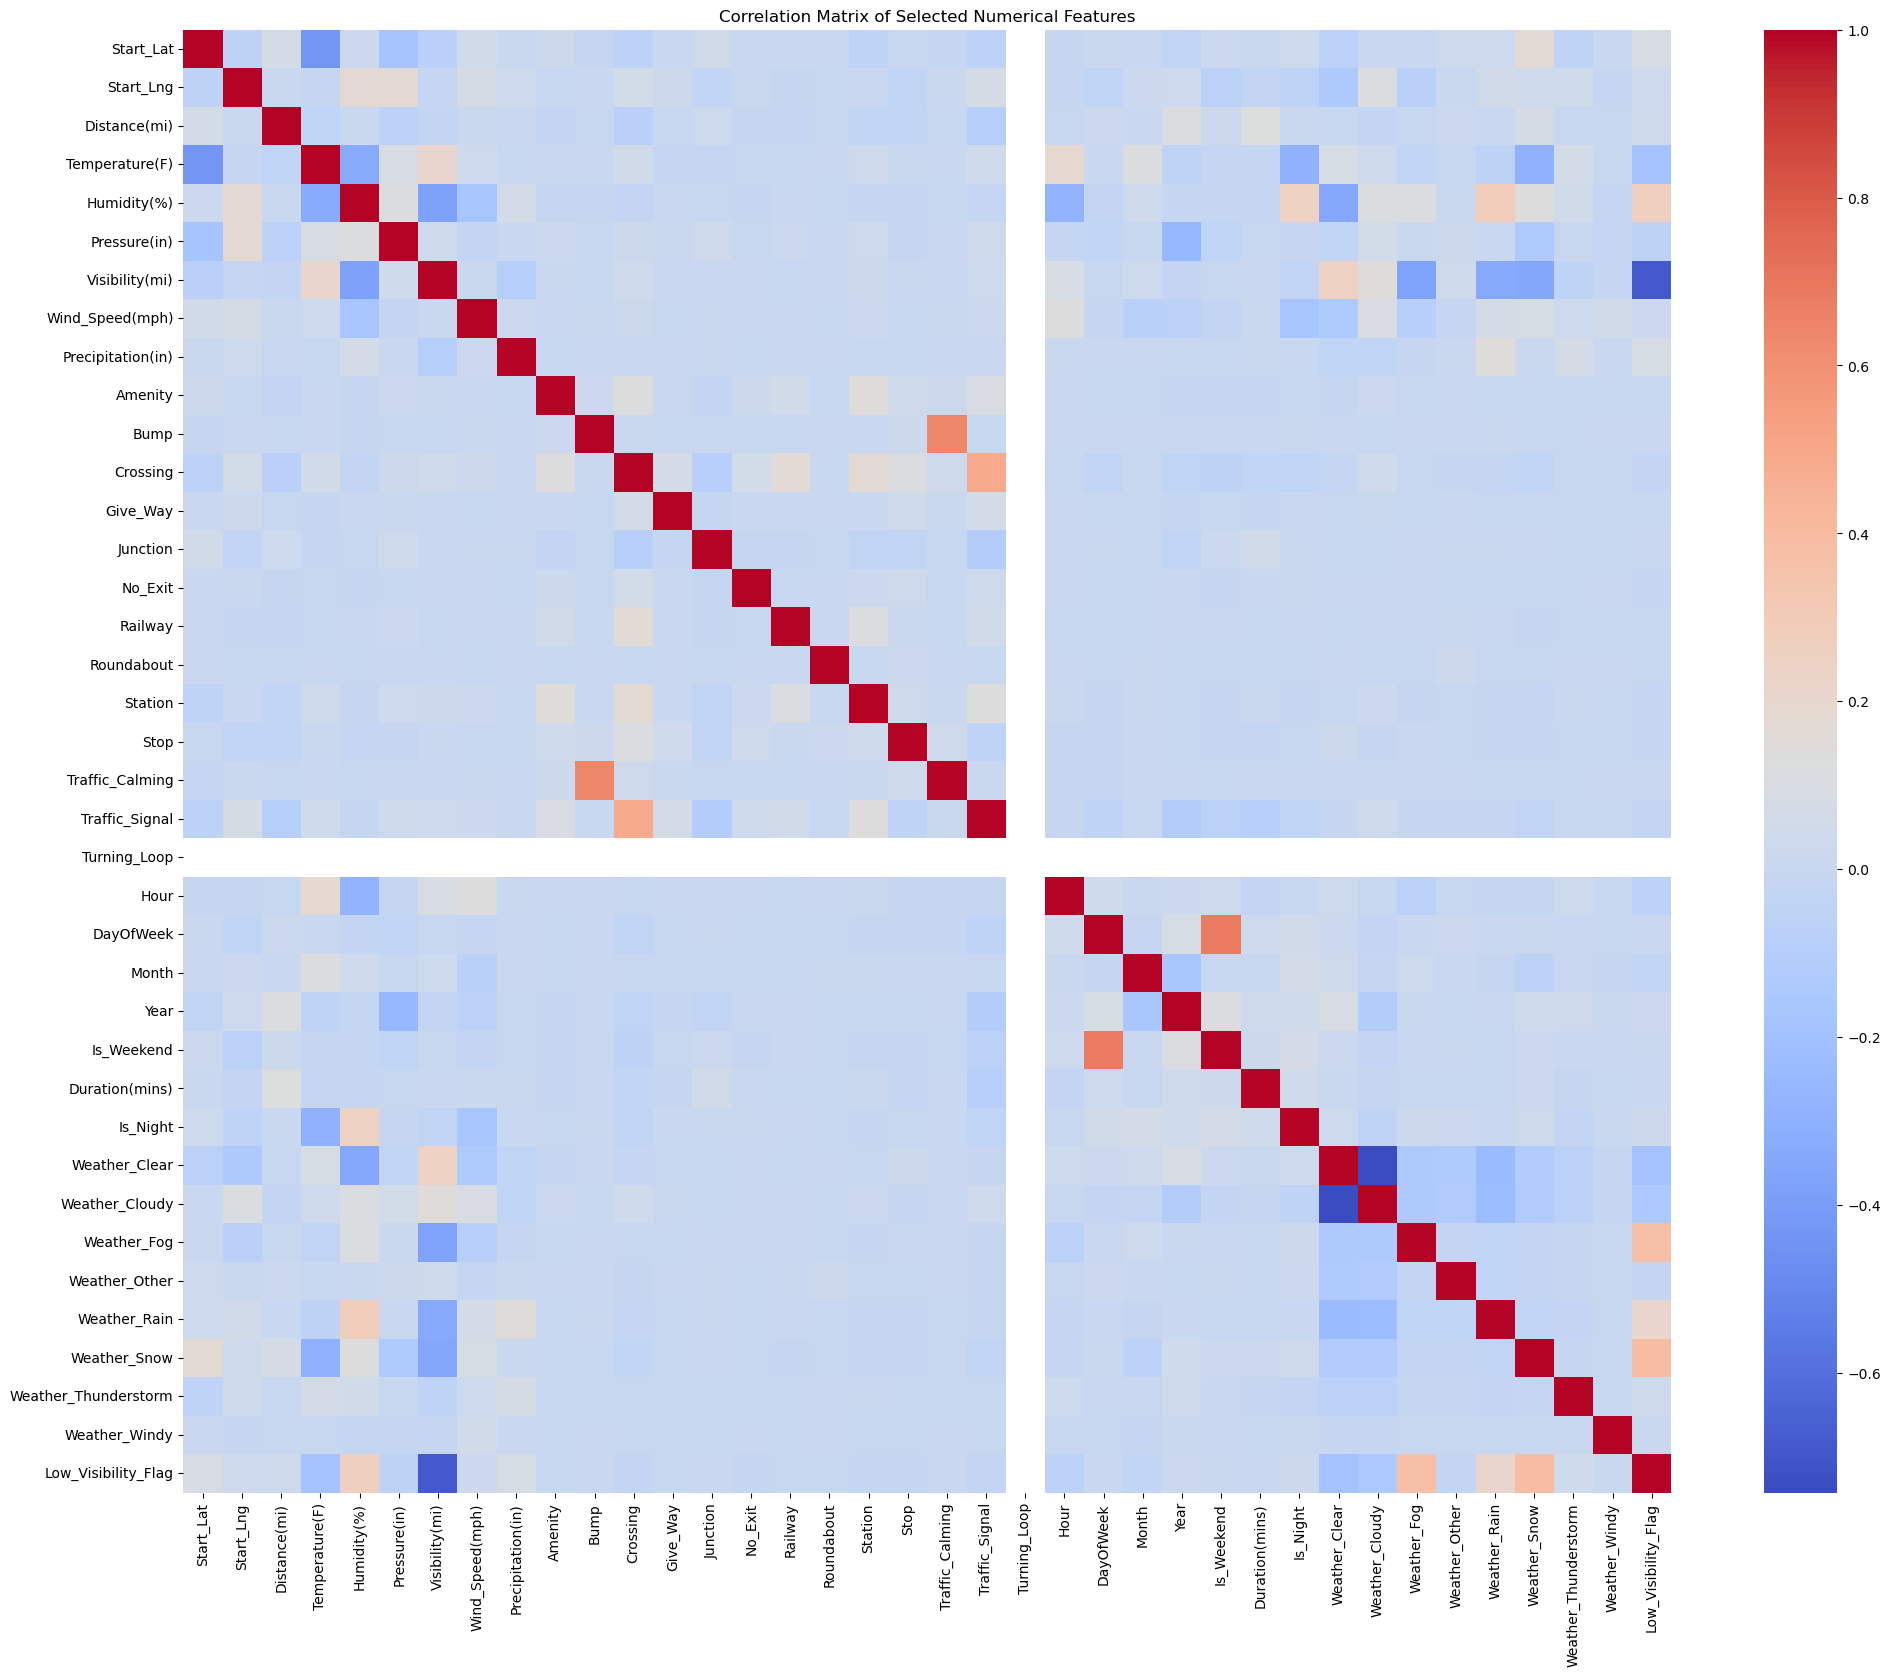


No feature pairs found with absolute correlation > 0.8.


In [5]:
# feature selection / correlation analysis

# columns to drop
columns_to_drop = [
    'ID',
    # Original Timestamp columns (replaced by engineered features)
    'Start_Time', 'End_Time', 'Weather_Timestamp',
    # Original columns replaced by engineered/encoded versions
    'Sunrise_Sunset', # -> isNight
    'Weather_Condition', # -> Weather_Simplified 
    'Weather_Simplified', # Intermediate use
    'Wind_Direction', # -> WindDir
    'State', 'Timezone', 'Source', 'County',
    'Country', # all vals are just 'US'
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
    'Wind_Chill(F)' #-> high corr w/ temp
]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_clean.columns]
print(f"\nColumns identified for dropping: {columns_to_drop_existing}")
df_selected = df_clean.drop(columns=columns_to_drop_existing, errors='ignore')

print(f"\nShape after dropping columns: {df_selected.shape}")
print("\nRemaining columns (features + target):")
print(df_selected.columns.tolist())

# Perform correlation analysis
numerical_cols = df_selected.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_cols if col != 'Severity']

print(f"\nCalculating correlation matrix for {len(numerical_features)} numerical features.")
correlation_matrix = df_selected[numerical_features].corr()

# visualization
plt.figure(figsize=(24, 19))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Selected Numerical Features")
plt.show()

# identifying high correlation pairs
threshold = 0.8
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            highly_correlated_pairs.append((col1, col2, corr_value))

if highly_correlated_pairs:
    print(f"\nFound pairs with correlation > {threshold} or < -{threshold}:")
    for pair in highly_correlated_pairs:
        print(f" - {pair[0]} and {pair[1]}: {pair[2]:.3f}")
else:
    print(f"\nNo feature pairs found with absolute correlation > {threshold}.")


df_selected.to_csv("processed_accidents.csv", index=False) #

In [6]:
import sklearn
from sklearn import model_selection 
datafram = pd.read_csv("processed_accidents.csv")
Y = datafram["Severity"]
datafram = datafram.drop(labels="Severity", axis=1)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(datafram, Y)
neighbors = sklearn.neighbors.KNeighborsClassifier(n_neighbors=20, p=1, n_jobs=-1) #manhattan distance with 20 neighbors seems to add 2-3% more accuracy
neighbors.fit(X_train, Y_train)
pred = neighbors.predict(X_test)
print("Accuracy:", sklearn.metrics.accuracy_score(Y_test, pred), "Confusion Matrix:\n", sklearn.metrics.confusion_matrix(Y_test, pred))

Accuracy: 0.7793764988009593 Confusion Matrix:
 [[   2  101    4    0]
 [   2 8553  187    1]
 [   0 1879  220    1]
 [   0  296   13    0]]


<module 'sklearn.ensemble' from 'C:\\Users\\dinco\\anaconda3\\Lib\\site-packages\\sklearn\\ensemble\\__init__.py'>

In [29]:
randForest = sklearn.ensemble.RandomForestClassifier(criterion="entropy", n_estimators=100)
randForest.fit(X_train, Y_train)
pred = randForest.predict(X_test)
print("Accuracy:", sklearn.metrics.accuracy_score(Y_test, pred))

Accuracy: 0.8064659383604228
